The Challenge is to detect partial discharge patterns in signals acquired from these power lines with a new meter designed at the ENET Centre at VSB. Effective classifiers using this data will make it possible to continuously monitor power lines for faults.

Inspired from Bruno Aquino's Kernel:
https://www.kaggle.com/braquino/5-fold-lstm-attention-fully-commented-0-694

I am using early stopping on the 5 Folds Stratified K Folds.

Updates : Removed Early Stopping and Batch Normalization because of lower accuracy. Included Dropout 

In [219]:
import pandas as pd
import pyarrow.parquet as pq # Used to read the data
import os 
import numpy as np
from keras.layers import * # Keras is the most friendly Neural Network library, this Kernel use a lot of layers classes
from keras.models import Model
from tqdm import tqdm # Processing time measurement
from sklearn.model_selection import train_test_split 
from keras import backend as K # The backend give us access to tensorflow operations and allow us to create the Attention class
from keras import optimizers # Allow us to access the Adam class to modify some parameters
from sklearn.model_selection import GridSearchCV, StratifiedKFold,RepeatedStratifiedKFold # Used to use Kfold to train our model
from keras.callbacks import * # This object helps the model to train in a smarter way, avoiding overfitting
import tensorflow as tf

In [220]:
# select how many folds will be created
N_SPLITS = 5
# it is just a constant with the measurements data size
sample_size = 800000

In [221]:
# It is the official metric used in this competition
# below is the declaration of a function used inside the keras model, calculation with K (keras backend / thensorflow)
def matthews_correlation(y_true, y_pred):
    '''Calculates the Matthews correlation coefficient measure for quality
    of binary classification problems.
    '''
    y_pred = tf.convert_to_tensor(y_pred, np.float32)
    y_true = tf.convert_to_tensor(y_true, np.float32)
    
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

In [222]:
# https://www.kaggle.com/suicaokhoailang/lstm-attention-baseline-0-652-lb

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [223]:
# just load train data
df_train = pd.read_csv('../input/metadata_train.csv')
# set index, it makes the data access much faster
df_train = df_train.set_index(['id_measurement', 'phase'])
df_train.head()

signal_id  target
id_measurement phase                   
0              0              0       0
               1              1       0
               2              2       0
1              0              3       1
               1              4       1

In [224]:
# in other notebook I have extracted the min and max values from the train data, the measurements
max_num = 127
min_num = -128

In [225]:
# This function standardize the data from (-128 to 127) to (-1 to 1)
# Theoretically it helps in the NN Model training, but I didn't tested without it
def min_max_transformation(ts, min_data, max_data, range_needed=(-1,1)):
    if min_data < 0:
        ts_std = (ts + abs(min_data)) / (max_data + abs(min_data))
    else:
        ts_std = (ts - min_data) / (max_data - min_data)
    if range_needed[0] < 0:    
        return ts_std * (range_needed[1] + abs(range_needed[0])) + range_needed[0]
    else:
        return ts_std * (range_needed[1] - range_needed[0]) + range_needed[0]

In [226]:
def transform_ts(ts, n_dim=160, min_max=(-1,1)):
    # convert data into -1 to 1
    ts_std = min_max_transformation(ts, min_data=min_num, max_data=max_num)
    # bucket or chunk size, 5000 in this case (800000 / 160)
    bucket_size = int(sample_size / n_dim)
    # new_ts will be the container of the new data
    new_ts = []
    # this for iteract any chunk/bucket until reach the whole sample_size (800000)
    for i in range(0, sample_size, bucket_size):
        # cut each bucket to ts_range
        ts_range = ts_std[i:i + bucket_size]
        # calculate each feature
        mean = ts_range.mean()
        std = ts_range.std() # standard deviation
        std_top = mean + std # I have to test it more, but is is like a band
        std_bot = mean - std
        # I think that the percentiles are very important, it is like a distribuiton analysis from eath chunk
        percentil_calc = np.percentile(ts_range, [0, 1, 25, 50, 75, 99, 100]) 
        max_range = percentil_calc[-1] - percentil_calc[0] # this is the amplitude of the chunk
        relative_percentile = percentil_calc - mean # maybe it could heap to understand the asymmetry
        new_ts.append(np.concatenate([np.asarray([mean, std, std_top, std_bot, max_range]),percentil_calc, relative_percentile]))
    return np.asarray(new_ts)

In [227]:
# this function take a piece of data and convert using transform_ts(), but it does to each of the 3 phases
# if we would try to do in one time, could exceed the RAM Memmory
def prepare_data(start, end):

    praq_train = pq.read_pandas('../input/train.parquet', columns=[str(i) for i in range(start, end)]).to_pandas()
    X = []
    y = []
   
    for id_measurement in tqdm(df_train.index.levels[0].unique()[int(start/3):int(end/3)]):
        X_signal = []
        # for each phase of the signal
        for phase in [0,1,2]:
            # extract from df_train both signal_id and target to compose the new data sets
            signal_id, target = df_train.loc[id_measurement].loc[phase]
            # but just append the target one time, to not triplicate it
            if phase == 0:
                y.append(target)
            # extract and transform data into sets of features
            X_signal.append(transform_ts(praq_train[str(signal_id)]))
        # concatenate all the 3 phases in one matrix
        X_signal = np.concatenate(X_signal, axis=1)
        # add the data to X
        X.append(X_signal)
    X = np.asarray(X)
    y = np.asarray(y)
    return X, y

In [228]:
# this code is very simple, divide the total size of the df_train into two sets and process it
X = []
y = []
def load_all():
    total_size = len(df_train)
    for ini, end in [(0, int(total_size/2)), (int(total_size/2), total_size)]:
        X_temp, y_temp = prepare_data(ini, end)
        X.append(X_temp)
        y.append(y_temp)
load_all()
X = np.concatenate(X)
y = np.concatenate(y)

100%|██████████| 1452/1452 [05:14<00:00,  4.77it/s]


In [229]:
print(X.shape, y.shape)
# save data into file, a numpy specific format
np.save("X.npy",X)
np.save("y.npy",y)

(2904, 160, 57) (2904,)


**Explorations on the New DataSet. I used Panel to convert the X and Y into Data Frames**

In [230]:
warnings.filterwarnings('ignore')

pan = pd.Panel(X)
df = pan.swapaxes(1, 2).to_frame()
df.index = df.index.droplevel('major')
df.index = df.index+1

In [231]:
df.shape

(9120, 2904)

In [232]:
df_y = pd.DataFrame(y.reshape(1,-1))

In [233]:
df_y.shape

(1, 2904)

**Lets check the Explorations for Mean, Standard Deviation, Skewness and Kurtosis on the Data generated**


**Lets check the Distribution of mean values per row in the training set**

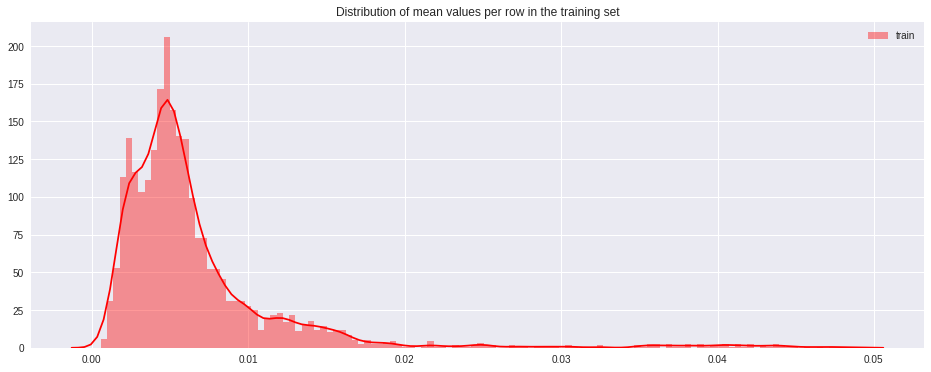

In [234]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')
from scipy.stats import norm, skew

plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the training set")
sns.distplot(df.mean(axis=0),color="red", kde=True,bins=120, label='train')
plt.legend()
plt.show()

**Lets check the Distribution of mean values per column in the training set**

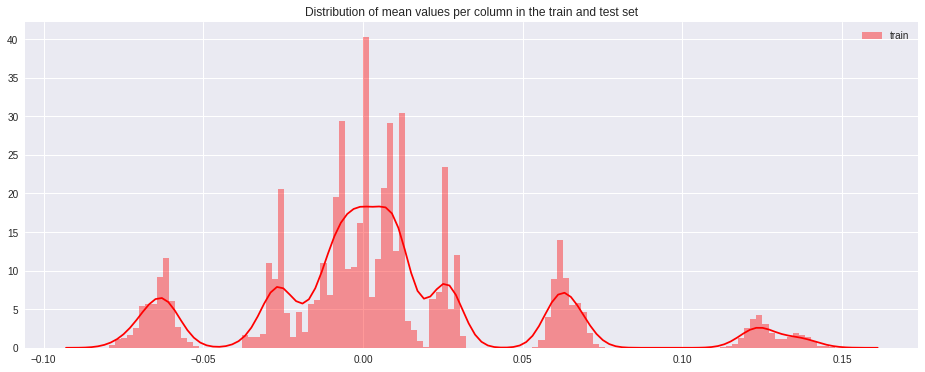

In [235]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(df.mean(axis=1),color="red", kde=True,bins=120, label='train')
plt.legend()
plt.show()

**Lets check the Distribution of S.D values per row in the training set**

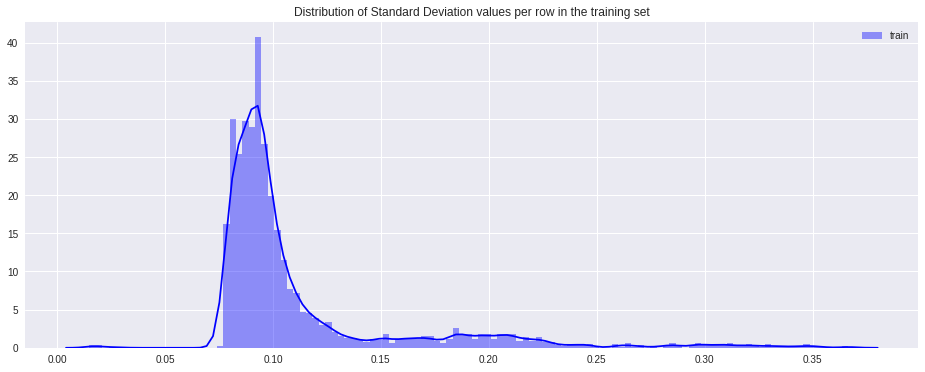

In [236]:
plt.figure(figsize=(16,6))
plt.title("Distribution of Standard Deviation values per row in the training set")
sns.distplot(df.std(axis=0),color="blue", kde=True,bins=120, label='train')
plt.legend()
plt.show()

**Lets check the Distribution of S.D values per column in the training set**

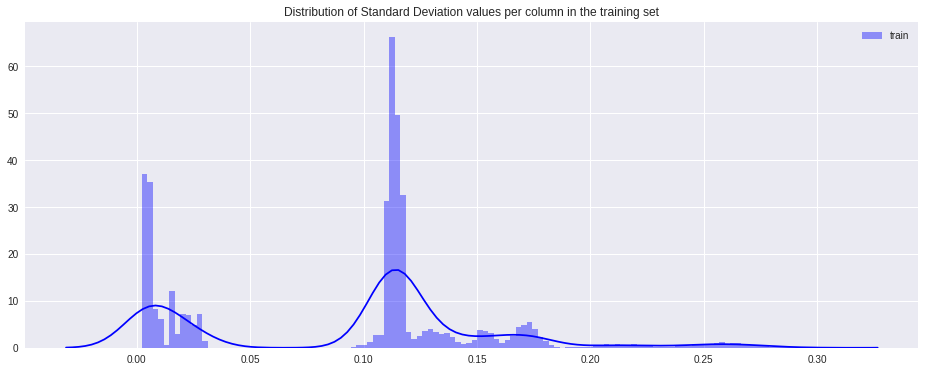

In [237]:
plt.figure(figsize=(16,6))
plt.title("Distribution of Standard Deviation values per column in the training set")
sns.distplot(df.std(axis=1),color="blue", kde=True,bins=120, label='train')
plt.legend()
plt.show()

**Lets check the Distribution of Skewness values per row in the training set**

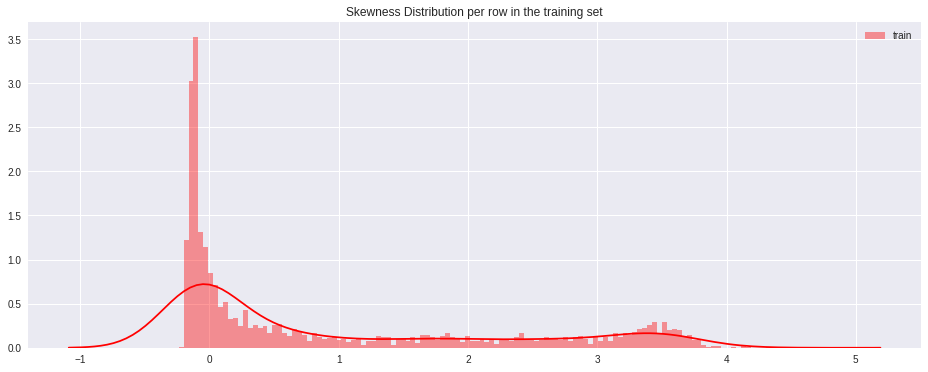

In [238]:
plt.figure(figsize=(16,6))
plt.title("Skewness Distribution per row in the training set")
sns.distplot(df.skew(axis=0),color="red", kde=True,bins=120, label='train')
plt.legend()
plt.show()

**Lets check the Distribution of Skewness values per column in the training set**

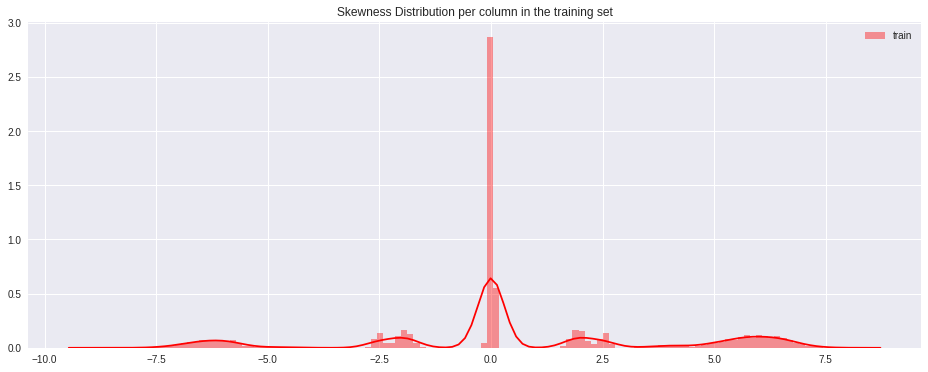

In [239]:
plt.figure(figsize=(16,6))
plt.title("Skewness Distribution per column in the training set")
sns.distplot(df.skew(axis=1),color="red", kde=True,bins=120, label='train')
plt.legend()
plt.show()

What we understand now, is the reason behind the BIModal behavior. Since the power line fault is detected in a very few cases, there is a presence of class imbalance in the dataset, which is valid for this kind of data.

**Lets check the Kurtosis Distribution values per row in the training set**

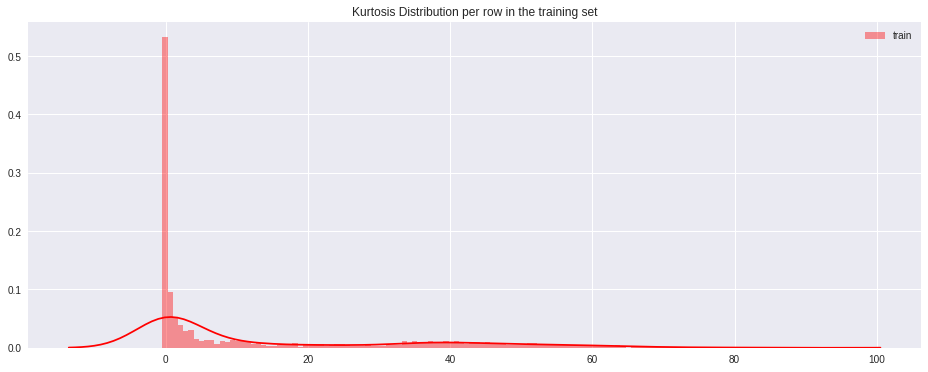

In [240]:
plt.figure(figsize=(16,6))
plt.title("Kurtosis Distribution per row in the training set")
sns.distplot(df.kurtosis(axis=0),color="red", kde=True,bins=120, label='train')
plt.legend()
plt.show()

**The distribution is Platokurtic.**

**Lets check the Kurtosis Distribution values per column in the training set**

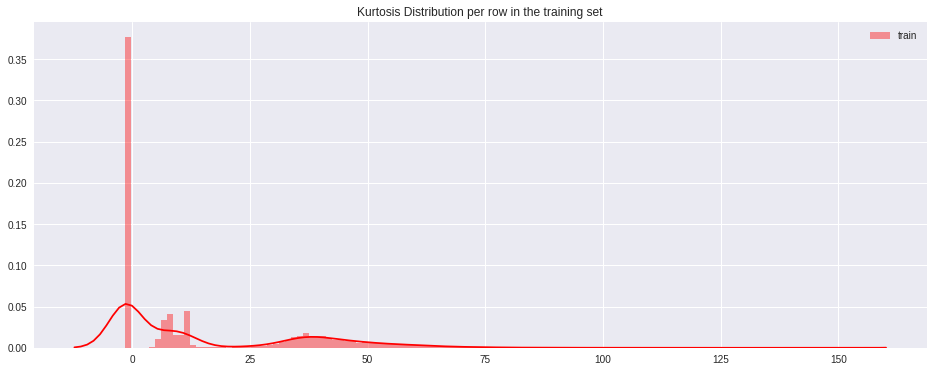

In [241]:
plt.figure(figsize=(16,6))
plt.title("Kurtosis Distribution per row in the training set")
sns.distplot(df.kurtosis(axis=1),color="red", kde=True,bins=120, label='train')
plt.legend()
plt.show()

Now Lets perform TSNE to see if the distribution is well seperated?

In [242]:
df.shape

(9120, 2904)

In [243]:
df_y.shape

(1, 2904)

Please note that since y's shape is different than X, i cant really use Y's for the color bar.  I am using a customized function for the color bar.

In [244]:
#Now let's use t-SNE to reduce dimensionality down to 2D so we can plot the dataset:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, verbose = 2)
TSNE_X = tsne.fit_transform(df)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9120 samples in 1.936s...
[t-SNE] Computed neighbors for 9120 samples in 183.134s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9120
[t-SNE] Computed conditional probabilities for sample 2000 / 9120
[t-SNE] Computed conditional probabilities for sample 3000 / 9120
[t-SNE] Computed conditional probabilities for sample 4000 / 9120
[t-SNE] Computed conditional probabilities for sample 5000 / 9120
[t-SNE] Computed conditional probabilities for sample 6000 / 9120
[t-SNE] Computed conditional probabilities for sample 7000 / 9120
[t-SNE] Computed conditional probabilities for sample 8000 / 9120
[t-SNE] Computed conditional probabilities for sample 9000 / 9120
[t-SNE] Computed conditional probabilities for sample 9120 / 9120
[t-SNE] Mean sigma: 0.068844
[t-SNE] Computed conditional probabilities in 0.515s
[t-SNE] Iteration 50: error = 94.9312592, gradient norm = 0.0144839 (50 iterations in 6.918s)
[t-SNE] Iteration 100

In [245]:
import matplotlib as mpl
min, max = (-40, 30)
step = 10

# Setting up a colormap that's a simple transtion
mymap = mpl.colors.LinearSegmentedColormap.from_list('mycolors',['green','yellow','red'])

# Using contourf to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = range(min,max+step,step)
CS3 = plt.contourf(Z, levels, cmap=mymap)
plt.clf()

<Figure size 576x396 with 0 Axes>

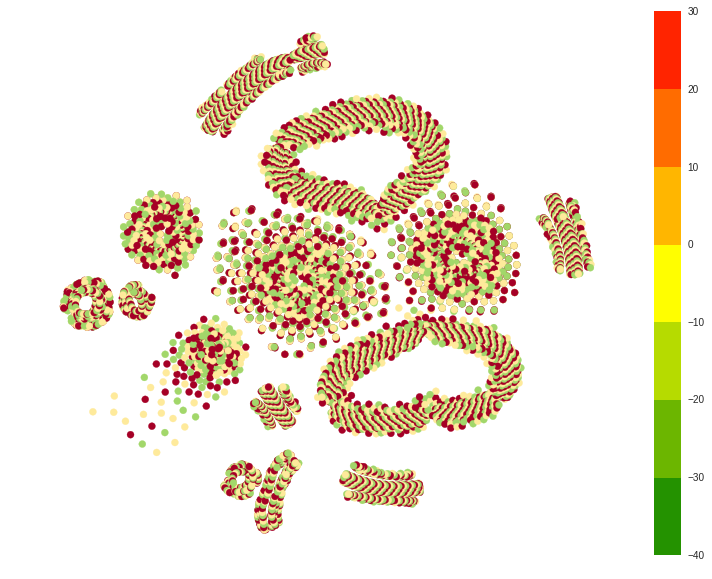

In [246]:
plt.figure(figsize=(13,10))
cm = plt.cm.get_cmap('RdYlGn_r')
colors=[cm(1*i) for i in [75,145,255]]
xy = range(3)
colorlist=[colors[x] for x in xy]
plt.scatter(TSNE_X[:, 0], TSNE_X[:, 1], c=colorlist, cmap=cm)
plt.colorbar(CS3)
plt.axis('off')
plt.show()

Now Lets perform PCA to see if the distribution is well seperated?

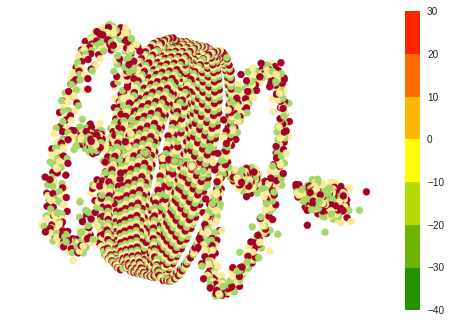

In [247]:
from sklearn.decomposition import PCA

PCA_train_x = PCA(n_components=200, random_state=42).fit_transform(df)
plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=colorlist, cmap=cm)
plt.axis('off')
plt.colorbar(CS3)
plt.show()

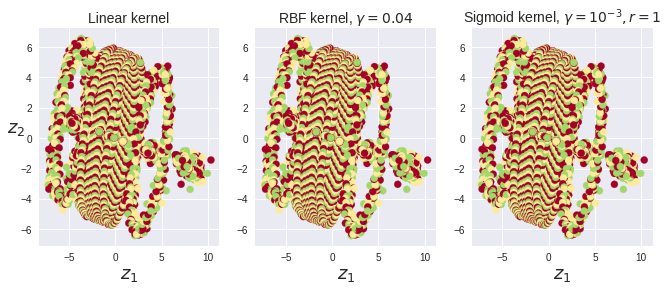

In [248]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)


plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
       
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=colorlist, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

After seeing the PCA model, I am eager to use Local Linear Embedding, as I do see the curve is resembling similar to a swiss roll.

In [249]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
lle_X = lle.fit_transform(df)

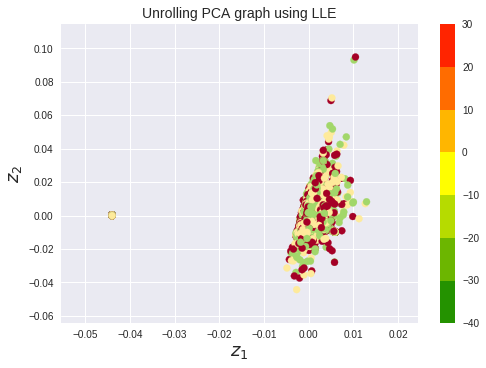

In [250]:
plt.title("Unrolling PCA graph using LLE", fontsize=14)
plt.scatter(lle_X[:, 0], lle_X[:, 1], c= colorlist, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.colorbar(CS3)
plt.grid(True)
plt.show()

**Building the RNN Model Architecture**


In [251]:
# This is NN LSTM Model creation
def model_lstm(input_shape):
    # The shape was explained above, must have this order
    inp = Input(shape=(input_shape[1], input_shape[2],))
    
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(inp)
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    
    x = Attention(input_shape[1])(x)
    
    x = Dense(64, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[matthews_correlation])
    
    return model

In [252]:
# First, create a set of indexes of the 5 folds
splits = list(StratifiedKFold(n_splits=N_SPLITS,random_state=42).split(X, y))
preds_val = []
y_val = []
# Then, iteract with each fold
# If you dont know, enumerate(['a', 'b', 'c']) returns [(0, 'a'), (1, 'b'), (2, 'c')]
for idx, (train_idx, val_idx) in enumerate(splits):
    K.clear_session() # I dont know what it do, but I imagine that it "clear session" :)
    print("Beginning fold {}".format(idx+1))
    train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
    model = model_lstm(train_X.shape)
    #es = EarlyStopping(monitor='val_matthews_correlation', verbose=2, patience=50, mode='max')
    ckpt = ModelCheckpoint('weights_{}.h5'.format(idx), save_best_only=True, save_weights_only=True, verbose=1, monitor='val_matthews_correlation', mode='max')
    # Train, train, train
    model.fit(train_X, train_y, batch_size=128, epochs=40, validation_data=[val_X, val_y], callbacks=[ckpt])
    # loads the best weights saved by the checkpoint
    model.load_weights('weights_{}.h5'.format(idx))
    # Add the predictions of the validation to the list preds_val
    preds_val.append(model.predict(val_X, batch_size=512))
    # and the val true y
    y_val.append(val_y)

# concatenates all and prints the shape    
preds_val = np.concatenate(preds_val)[...,0]
y_val = np.concatenate(y_val)
preds_val.shape, y_val.shape

Beginning fold 1
Train on 2322 samples, validate on 582 samples
Epoch 1/40
2322/2322 [==============================] - 5s 2ms/step - loss: 0.3637 - matthews_correlation: 0.0044 - val_loss: 0.2316 - val_matthews_correlation: 0.0000e+00

Epoch 00001: val_matthews_correlation improved from -inf to 0.00000, saving model to weights_0.h5
Epoch 2/40
2322/2322 [==============================] - 1s 480us/step - loss: 0.2404 - matthews_correlation: 0.0000e+00 - val_loss: 0.2328 - val_matthews_correlation: 0.0000e+00

Epoch 00002: val_matthews_correlation did not improve from 0.00000
Epoch 3/40
2322/2322 [==============================] - 1s 482us/step - loss: 0.2302 - matthews_correlation: 0.0000e+00 - val_loss: 0.2293 - val_matthews_correlation: 0.0000e+00

Epoch 00003: val_matthews_correlation did not improve from 0.00000
Epoch 4/40
2322/2322 [==============================] - 1s 480us/step - loss: 0.2262 - matthews_correlation: 0.0000e+00 - val_loss: 0.2201 - val_matthews_correlation: 0.0000

2322/2322 [==============================] - 1s 443us/step - loss: 0.0880 - matthews_correlation: 0.7104 - val_loss: 0.1056 - val_matthews_correlation: 0.5415

Epoch 00034: val_matthews_correlation did not improve from 0.59739
Epoch 35/40
2322/2322 [==============================] - 1s 442us/step - loss: 0.0907 - matthews_correlation: 0.6886 - val_loss: 0.1129 - val_matthews_correlation: 0.5956

Epoch 00035: val_matthews_correlation did not improve from 0.59739
Epoch 36/40
2322/2322 [==============================] - 1s 442us/step - loss: 0.0971 - matthews_correlation: 0.6467 - val_loss: 0.1016 - val_matthews_correlation: 0.5595

Epoch 00036: val_matthews_correlation did not improve from 0.59739
Epoch 37/40
2322/2322 [==============================] - 1s 441us/step - loss: 0.0901 - matthews_correlation: 0.6549 - val_loss: 0.1130 - val_matthews_correlation: 0.6045

Epoch 00037: val_matthews_correlation improved from 0.59739 to 0.60454, saving model to weights_0.h5
Epoch 38/40
2322/2322 

2323/2323 [==============================] - 1s 488us/step - loss: 0.0849 - matthews_correlation: 0.6988 - val_loss: 0.1401 - val_matthews_correlation: 0.5514

Epoch 00027: val_matthews_correlation did not improve from 0.61932
Epoch 28/40
2323/2323 [==============================] - 1s 491us/step - loss: 0.0843 - matthews_correlation: 0.7281 - val_loss: 0.1314 - val_matthews_correlation: 0.6026

Epoch 00028: val_matthews_correlation did not improve from 0.61932
Epoch 29/40
2323/2323 [==============================] - 1s 491us/step - loss: 0.0811 - matthews_correlation: 0.6934 - val_loss: 0.1303 - val_matthews_correlation: 0.5500

Epoch 00029: val_matthews_correlation did not improve from 0.61932
Epoch 30/40
2323/2323 [==============================] - 1s 488us/step - loss: 0.0806 - matthews_correlation: 0.7582 - val_loss: 0.1282 - val_matthews_correlation: 0.6212

Epoch 00030: val_matthews_correlation improved from 0.61932 to 0.62116, saving model to weights_1.h5
Epoch 31/40
2323/2323 


Epoch 00019: val_matthews_correlation did not improve from 0.63635
Epoch 20/40
2323/2323 [==============================] - 1s 449us/step - loss: 0.0976 - matthews_correlation: 0.6282 - val_loss: 0.0808 - val_matthews_correlation: 0.6342

Epoch 00020: val_matthews_correlation did not improve from 0.63635
Epoch 21/40
2323/2323 [==============================] - 1s 450us/step - loss: 0.1025 - matthews_correlation: 0.6248 - val_loss: 0.0900 - val_matthews_correlation: 0.6369

Epoch 00021: val_matthews_correlation improved from 0.63635 to 0.63688, saving model to weights_2.h5
Epoch 22/40
2323/2323 [==============================] - 1s 453us/step - loss: 0.1005 - matthews_correlation: 0.6562 - val_loss: 0.0875 - val_matthews_correlation: 0.6363

Epoch 00022: val_matthews_correlation did not improve from 0.63688
Epoch 23/40
2323/2323 [==============================] - 1s 447us/step - loss: 0.0965 - matthews_correlation: 0.6726 - val_loss: 0.0829 - val_matthews_correlation: 0.6441

Epoch 000

2324/2324 [==============================] - 1s 485us/step - loss: 0.1076 - matthews_correlation: 0.6326 - val_loss: 0.1217 - val_matthews_correlation: 0.4768

Epoch 00012: val_matthews_correlation did not improve from 0.52042
Epoch 13/40
2324/2324 [==============================] - 1s 486us/step - loss: 0.1101 - matthews_correlation: 0.6401 - val_loss: 0.1136 - val_matthews_correlation: 0.5086

Epoch 00013: val_matthews_correlation did not improve from 0.52042
Epoch 14/40
2324/2324 [==============================] - 1s 483us/step - loss: 0.1028 - matthews_correlation: 0.6392 - val_loss: 0.1226 - val_matthews_correlation: 0.4864

Epoch 00014: val_matthews_correlation did not improve from 0.52042
Epoch 15/40
2324/2324 [==============================] - 1s 485us/step - loss: 0.0973 - matthews_correlation: 0.6495 - val_loss: 0.1096 - val_matthews_correlation: 0.3515

Epoch 00015: val_matthews_correlation did not improve from 0.52042
Epoch 16/40
2324/2324 [==============================] -


Epoch 00005: val_matthews_correlation did not improve from 0.00000
Epoch 6/40
2324/2324 [==============================] - 1s 439us/step - loss: 0.1609 - matthews_correlation: -0.0032 - val_loss: 0.1535 - val_matthews_correlation: 0.0000e+00

Epoch 00006: val_matthews_correlation did not improve from 0.00000
Epoch 7/40
2324/2324 [==============================] - 1s 439us/step - loss: 0.1504 - matthews_correlation: 0.1507 - val_loss: 0.1352 - val_matthews_correlation: 0.2633

Epoch 00007: val_matthews_correlation improved from 0.00000 to 0.26335, saving model to weights_4.h5
Epoch 8/40
2324/2324 [==============================] - 1s 438us/step - loss: 0.1294 - matthews_correlation: 0.3345 - val_loss: 0.1033 - val_matthews_correlation: 0.5255

Epoch 00008: val_matthews_correlation improved from 0.26335 to 0.52547, saving model to weights_4.h5
Epoch 9/40
2324/2324 [==============================] - 1s 438us/step - loss: 0.1202 - matthews_correlation: 0.5733 - val_loss: 0.1115 - val_matt

2324/2324 [==============================] - 1s 480us/step - loss: 0.0953 - matthews_correlation: 0.7001 - val_loss: 0.0954 - val_matthews_correlation: 0.5607

Epoch 00039: val_matthews_correlation did not improve from 0.76400
Epoch 40/40
2324/2324 [==============================] - 1s 482us/step - loss: 0.0910 - matthews_correlation: 0.7138 - val_loss: 0.0954 - val_matthews_correlation: 0.5694

Epoch 00040: val_matthews_correlation did not improve from 0.76400


((2904,), (2904,))

In [253]:
import tensorflow as tf

def threshold_search(y_true, y_proba):
    best_threshold = 0
    best_score = 0
    for threshold in tqdm([i * 0.01 for i in range(100)]):
        score = K.eval(matthews_correlation(y_true.astype(np.float64), (y_proba > threshold).astype(np.float64)))
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'matthews_correlation': best_score}
    return search_result

In [254]:
best_threshold = threshold_search(y_val, preds_val)['threshold']

100%|██████████| 100/100 [00:18<00:00,  3.74it/s]


In [255]:
best_threshold

0.51

In [256]:
meta_test = pd.read_csv('../input/metadata_test.csv')

In [257]:
meta_test = meta_test.set_index(['signal_id'])
meta_test.head()

,id_measurement,phase
signal_id,,
8712,2904,0
8713,2904,1
8714,2904,2
8715,2905,0
8716,2905,1


In [ ]:
first_sig = meta_test.index[0]
n_parts = 10
max_line = len(meta_test)
part_size = int(max_line / n_parts)
last_part = max_line % n_parts
print(first_sig, n_parts, max_line, part_size, last_part, n_parts * part_size + last_part)
# Here we create a list of lists with start index and end index for each of the 10 parts and one for the last partial part
start_end = [[x, x+part_size] for x in range(first_sig, max_line + first_sig, part_size)]
start_end = start_end[:-1] + [[start_end[-1][0], start_end[-1][0] + last_part]]
print(start_end)
X_test = []
# now, very like we did above with the train data, we convert the test data part by part
# transforming the 3 phases 800000 measurement in matrix (160,57)
for start, end in start_end:
    subset_test = pq.read_pandas('../input/test.parquet', columns=[str(i) for i in range(start, end)]).to_pandas()
    for i in tqdm(subset_test.columns):
        id_measurement, phase = meta_test.loc[int(i)]
        subset_test_col = subset_test[i]
        subset_trans = transform_ts(subset_test_col)
        X_test.append([i, id_measurement, phase, subset_trans])

8712 10 20337 2033 7 20337
[[8712, 10745], [10745, 12778], [12778, 14811], [14811, 16844], [16844, 18877], [18877, 20910], [20910, 22943], [22943, 24976], [24976, 27009], [27009, 29042], [29042, 29049]]


  2%|▏         | 44/2033 [00:03<02:19, 14.30it/s]

In [ ]:
X_test_input = np.asarray([np.concatenate([X_test[i][3],X_test[i+1][3], X_test[i+2][3]], axis=1) for i in range(0,len(X_test), 3)])
np.save("X_test.npy",X_test_input)
X_test_input.shape

In [ ]:
submission = pd.read_csv('../input/sample_submission.csv')
print(len(submission))
submission.head()

In [ ]:
preds_test = []
for i in range(N_SPLITS):
    model.load_weights('weights_{}.h5'.format(i))
    pred = model.predict(X_test_input, batch_size=300, verbose=1)
    pred_3 = []
    for pred_scalar in pred:
        for i in range(3):
            pred_3.append(pred_scalar)
    preds_test.append(pred_3)


In [ ]:
preds_test = (np.squeeze(np.mean(preds_test, axis=0)) > best_threshold).astype(np.int)
preds_test.shape

In [ ]:
submission['target'] = preds_test
submission.to_csv('submission.csv', index=False)
submission.head()